In [1]:
import warnings

import pooch

# don't have pooch output messages about downloading or untarring
logger = pooch.get_logger()
logger.setLevel("WARNING")

warnings.filterwarnings(
    "ignore",
    message="The default behavior of tarfile extraction",
    category=RuntimeWarning,
)

:::{admonition} Download
:class: important

Download this notebook: **{nb-download}`Perceptual_distance.ipynb`**!

:::

# Perceptual distance

The easiest way to measure the difference between two images is by computing the mean square error (MSE), but it does not match the perceptual distance judged by humans. Several perceptual distance functions have been developed to better match human perception. This tutorial introduces three perceptual distance functions available in `plenoptic` package: [SSIM](plenoptic.metric.perceptual_distance.ssim) (structural similarity), [MS-SSIM](plenoptic.metric.perceptual_distance.ms_ssim) (multiscale structural similarity) and [NLPD](plenoptic.metric.perceptual_distance.nlpd) (normalized Laplacian pyramid distance).

## References

**SSIM**: [Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P. (2004). Image quality assessment: from error visibility to structural similarity. _IEEE transactions on image processing_, 13(4), 600-612.](https://www.cns.nyu.edu/pub/lcv/wang03-reprint.pdf)

**MS-SSIM**: [Wang, Z., Simoncelli, E. P., & Bovik, A. C. (2003, November). Multiscale structural similarity for image quality assessment. In _The Thrity-Seventh Asilomar Conference on Signals, Systems & Computers_, 2003 (Vol. 2, pp. 1398-1402). IEEE.](https://www.cns.nyu.edu/pub/eero/wang03b.pdf)

**NLPD**: [Laparra, V., Ballé, J., Berardino, A., & Simoncelli, E. P. (2016). Perceptual image quality assessment using a normalized Laplacian pyramid. _Electronic Imaging_, 2016(16), 1-6.](https://www.cns.nyu.edu/pub/lcv/laparra16a-reprint.pdf)

In [2]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import pearsonr, spearmanr

import plenoptic as po

# this notebook runs just about as fast with GPU and CPU
DEVICE = torch.device("cpu")

## SSIM (structural similarity)

The idea of SSIM index is to decompose the difference between two images into three components: luminance, contrast and structure. For two small image patches $\mathbf{x}$ and $\mathbf{y}$, these three components of difference are defined as:

\begin{gather*}
l(\mathbf{x}, \mathbf{y}) = \frac{2 \mu_x \mu_y + C_1}{\mu_x^2 + \mu_y^2 + C_1}\\
c(\mathbf{x}, \mathbf{y}) = \frac{2 \sigma_x \sigma_y + C_2}{\sigma_x^2 + \sigma_y^2 + C_2}\\
s(\mathbf{x}, \mathbf{y}) = \frac{\sigma_{xy} + C_3}{\sigma_x \sigma_y + C_3}
\end{gather*}

where:

- $\mu_x$ and $\mu_y$ are the mean of $\mathbf{x}$ and $\mathbf{y}$,
- $\sigma_x$ and $\sigma_y$ are the standard deviation of $\mathbf{x}$ and $\mathbf{y}$,
- $\sigma_{xy}$ is the covariance between $\mathbf{x}$ and $\mathbf{y}$
- $C_1, C_2, C_3$ are small constants.

If we ignore the small constants, we can see that the luminance term $l(\mathbf{x}, \mathbf{y})$ is a scale-invariant similarity measurement between $\mu_x$ and $\mu_y$, and the contrast term $c(\mathbf{x}, \mathbf{y})$ is such a measurement between $\sigma_x$ and $\sigma_y$. The structural term $s(\mathbf{x}, \mathbf{y})$ is the correlation coefficient between $\mathbf{x}$ and $\mathbf{y}$, which is invariant to addition and multiplication of constants on $\mathbf{x}$ or $\mathbf{y}$.

Local SSIM between two small image patches $\mathbf{x}$ and $\mathbf{y}$ is defined as (let $C_3 = C_2 / 2$):

\begin{align*}
d(\mathbf{x}, \mathbf{y}) &= l(\mathbf{x}, \mathbf{y}) c(\mathbf{x}, \mathbf{y}) s(\mathbf{x}, \mathbf{y})\\
&= \frac{\left( 2 \mu_x \mu_y + C_1 \right) \left( 2\sigma_{xy} + C_2 \right)} {\left( \mu_x^2 + \mu_y^2 + C_1 \right) \left( \sigma_x^2 + \sigma_y^2 + C_2 \right)}
\end{align*}

The local SSIM value $d(\mathbf{x}, \mathbf{y}) = 1$ means the two patches are identical and $d(\mathbf{x}, \mathbf{y}) = 0$ means they're very different. When the two patches are negatively correlated, $d(\mathbf{x}, \mathbf{y})$ can be negative. The local SSIM value is bounded between -1 and 1.

For two full images $\mathbf{X}, \mathbf{Y}$, an SSIM map is obtained by computing the local SSIM value $d$ across the whole image. For each position on the images, instead of using a square patch centered on it, a circular-symmeric Gaussian kernel is used to compute the local mean, standard deviation and covariance terms $\mu_{X,i}, \mu_{Y,i}, \sigma_{X,i}, \sigma_{Y,i}, \sigma_{XY,i}$, where $i$ is the pixel index. In this way we can obtain an SSIM map $d_i(\mathbf{X}, \mathbf{Y})$. The values in the SSIM map are averaged to generate a single number, which is the SSIM index:

\begin{align*}
\text{SSIM}(\mathbf{X}, \mathbf{Y}) &= \frac{1}{N} \sum_{i=1}^N d_i(\mathbf{X}, \mathbf{Y})\\
&= \frac{1}{N} \sum_{i=1}^N l_i(\mathbf{X}, \mathbf{Y}) c_i(\mathbf{X}, \mathbf{Y}) s_i(\mathbf{X}, \mathbf{Y})\\
&= \frac{1}{N} \sum_{i=1}^N \frac{\left( 2 \mu_{X,i} \mu_{Y,i} + C_1 \right) \left( 2\sigma_{XY,i} + C_2 \right)} {\left( {\mu_{X,i}}^2 + {\mu_{Y,i}}^2 + C_1 \right) \left( {\sigma_{X,i}}^2 + {\sigma_{Y,i}}^2 + C_2 \right)}
\end{align*}

where $N$ is the number of pixels of the image. The SSIM index is also bounded between -1 and 1.  In `plenoptic`, the SSIM map is computed by the function {func}`~plenoptic.metric.perceptual_distance.ssim_map`, and the SSIM index itself is computed by the function {func}`~plenoptic.metric.perceptual_distance.ssim`. For more information, see the original paper:

[Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P. (2004). Image quality assessment: from error visibility to structural similarity. _IEEE transactions on image processing_, 13(4), 600-612.](https://www.cns.nyu.edu/pub/lcv/wang03-reprint.pdf)

### Understanding SSIM

We demonstrate the effectiveness of SSIM by generating five different types of distortions (contrast stretching, mean shifting, JPEG compression, blurring, and salt-pepper noise) with the same MSE, and computing their SSIM values.

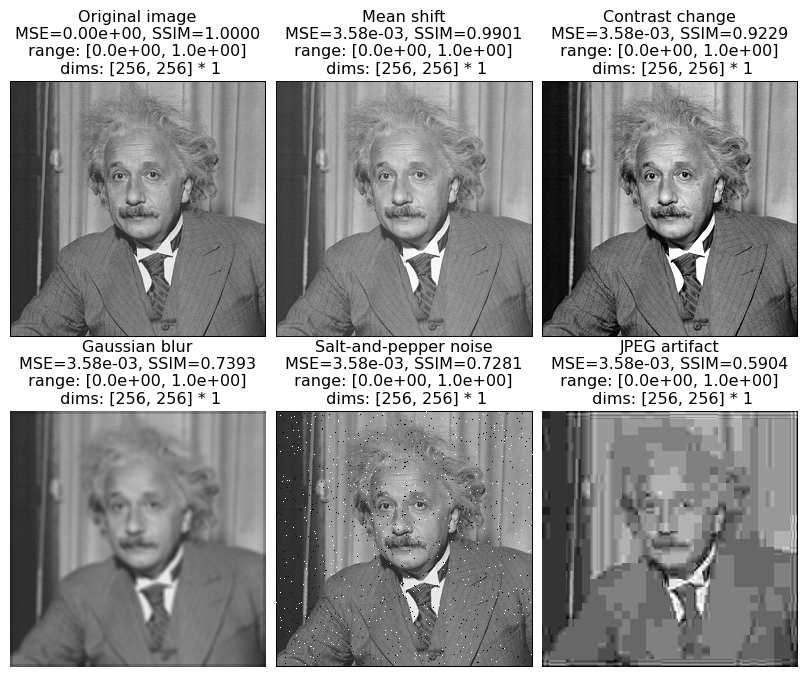

In [3]:
import tempfile


def add_jpeg_artifact(img, quality):
    # need to convert this back to 2d 8-bit int for writing out as jpg
    img = po.to_numpy(img.squeeze() * 255).astype(np.uint8)
    # write to a temporary file
    with tempfile.NamedTemporaryFile(suffix=".jpg") as tmp:
        imageio.imwrite(tmp.name, img, quality=quality)
        img = po.load_images(tmp.name)
    return img


def add_saltpepper_noise(img, threshold):
    po.tools.set_seed(0)
    img_saltpepper = img.clone()
    for i in range(img.shape[-2]):
        for j in range(img.shape[-1]):
            x = np.random.rand()
            if x < threshold:
                img_saltpepper[..., i, j] = 0
            elif x > 1 - threshold:
                img_saltpepper[..., i, j] = 1
    np.random.seed(None)
    return img_saltpepper


def get_distorted_images():
    img = po.data.einstein()
    img_mean = torch.clip(img + 0.05983, min=0, max=1)
    img_contrast = torch.clip(img + 0.20515 * (2 * img - 1), min=0, max=1)
    img_blur = po.simul.Gaussian(5, std=2.68)(img)
    img_saltpepper = add_saltpepper_noise(img, threshold=0.00651)
    img_jpeg = add_jpeg_artifact(img, quality=4)
    img_distorted = torch.cat(
        [img, img_mean, img_contrast, img_blur, img_saltpepper, img_jpeg],
        axis=0,
    )
    return img_distorted.to(DEVICE)


img_distorted = get_distorted_images()
mse_values = torch.square(img_distorted - img_distorted[0]).mean(dim=(1, 2, 3))
ssim_values = po.metric.ssim(img_distorted, img_distorted[[0]])[:, 0]
names = [
    "Original image",
    "Mean shift",
    "Contrast change",
    "Gaussian blur",
    "Salt-and-pepper noise",
    "JPEG artifact",
]
titles = [
    f"{names[i]}\nMSE={mse_values[i]:.2e}, SSIM={ssim_values[i]:.4f}" for i in range(6)
]
po.imshow(img_distorted, vrange="auto", title=titles, col_wrap=3);

We can see that, while MSE is identical for all the distorted images, SSIM decreases as we go from left to right, top to bottom. Thus, SSIM matches human perception better than MSE.

While the scalar SSIM index is a concise summary, the SSIM map offers richer information about where perceptual discrepancy is located in the image. Here, we visualize the SSIM map of a JPEG compressed image, and also show the absolute error (absolute value of the difference) for comparison. In both maps, darker means more different.

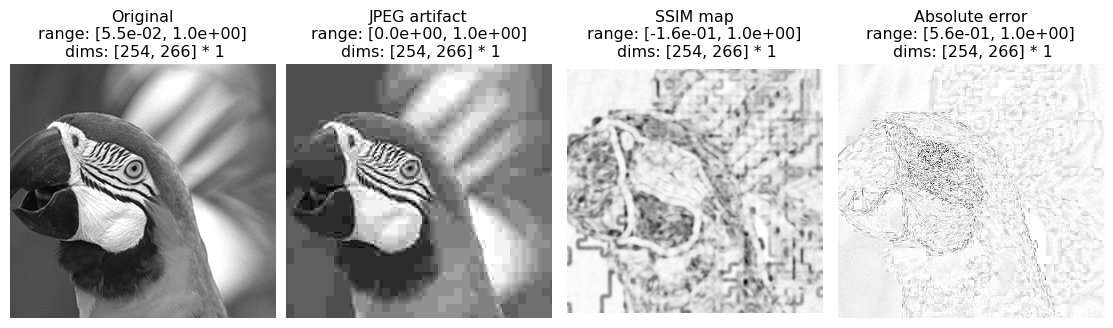

In [4]:
def get_demo_images():
    img = po.data.parrot(as_gray=True)
    img_jpeg = add_jpeg_artifact(img, quality=6)
    ssim_map_small = po.metric.ssim_map(img, img_jpeg)
    ssim_map = torch.ones_like(img)
    ssim_map[:, :, 5:-5, 5:-5] = ssim_map_small
    abs_map = 1 - torch.abs(img - img_jpeg)
    img_demo = torch.cat([img, img_jpeg, ssim_map, abs_map], dim=0).cpu()
    return img_demo


img_demo = get_demo_images()
titles = ["Original", "JPEG artifact", "SSIM map", "Absolute error"]
po.imshow(img_demo, title=titles);

You can judge whether the SSIM map captures the location of perceptual discrepancy better than absolute error.

## MS-SSIM (multiscale structural similarity)

MS-SSIM computes SSIM on multiple scales of the images. To do this, the two images $\mathbf{X}$ and $\mathbf{Y}$ are recursively blurred and downsampled by a factor of 2 to produce two sequences of images: $\mathbf{X}_1, \cdots, \mathbf{X}_M$ and $\mathbf{Y}_1, \cdots, \mathbf{Y}_M$, where $\mathbf{X}_1 = \mathbf{X}$, and $\mathbf{X}_{i+1}$ is obtained by blurring and downsampling $\mathbf{X}_{i}$ (same for $\mathbf{Y}$). Such a sequence is called a Gaussian pyramid. We define a contrast-structural index that does not include luminance component:

\begin{align*}
\text{CS}(\mathbf{X}, \mathbf{Y}) &= \frac{1}{N} \sum_{i=1}^N c_i(\mathbf{X}, \mathbf{Y}) s_i(\mathbf{X}, \mathbf{Y})\\
&= \frac{1}{N} \sum_{i=1}^N \frac{2\sigma_{XY,i} + C_2} {{\sigma_{X,i}}^2 + {\sigma_{Y,i}}^2 + C_2}
\end{align*}

The MS-SSIM index is defined as:

$$
\text{MS-SSIM}(\mathbf{X}, \mathbf{Y}) = \text{SSIM}(\mathbf{X}_M, \mathbf{Y}_M)^{\gamma_M} \prod_{k=1}^{M-1} \text{CS}(\mathbf{X}_i, \mathbf{Y}_i)^{\gamma_i}
$$

where $\gamma_1, \cdots, \gamma_M$ are exponents that determine the relative importance of different scales. They are determined by a human psychophysics experiment and are constrained to sum to 1. When $M=1$, the MS-SSIM index is the same as the SSIM index. In the standard implementation of MS-SSIM, $M = 5$. In `plenoptic`, the MS-SSIM index is computed by the function {func}`~plenoptic.metric.perceptual_distance.ms_ssim`. For more information, see the original paper:

[Wang, Z., Simoncelli, E. P., & Bovik, A. C. (2003, November). Multiscale structural similarity for image quality assessment. In _The Thrity-Seventh Asilomar Conference on Signals, Systems & Computers_, 2003 (Vol. 2, pp. 1398-1402). IEEE.](https://www.cns.nyu.edu/pub/eero/wang03b.pdf)

Here we use the same distortions on Einstein image to demonstrate MS-SSIM:

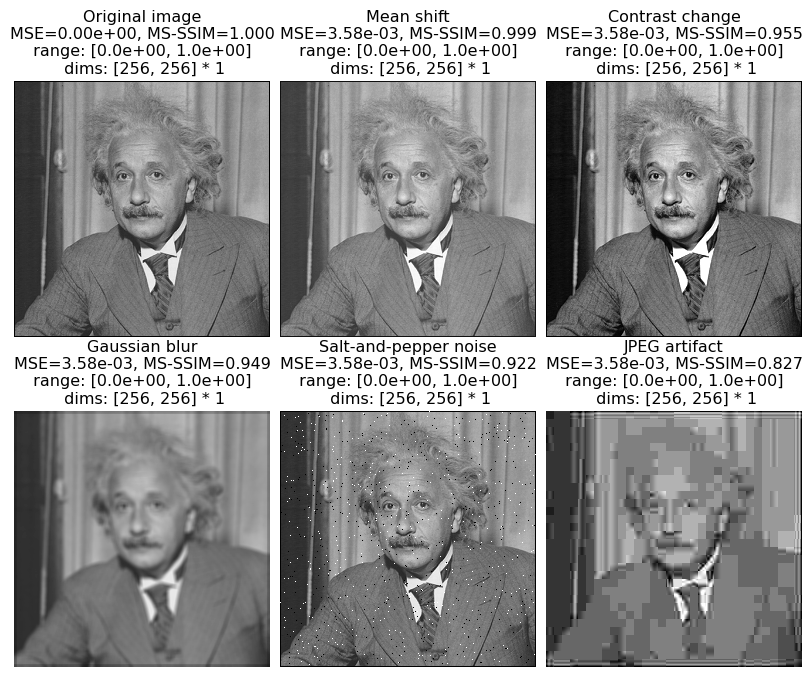

In [5]:
msssim_values = po.metric.ms_ssim(img_distorted, img_distorted[[0]])[:, 0]
titles = [
    f"{names[i]}\nMSE={mse_values[i]:.2e}, MS-SSIM={msssim_values[i]:.3f}"
    for i in range(6)
]
po.imshow(img_distorted, vrange="auto", title=titles, col_wrap=3);

## NLPD (normalized Laplacian pyramid distance)

Similar to MS-SSIM, the NLPD is also based on a multiscale representation of the images. Also similar to MS-SSIM, the idea of NLPD is also to separate out the effects of luminance and contrast difference. Unlike MS-SSIM, the NLPD directly performs luminance subtraction and contrast normalization on each scale, and then computes simple square difference. The NLPD uses the Laplacian pyramid for luminance subtraction. Given a Gaussian pyramid $\mathbf{X}_1, \cdots, \mathbf{X}_M$, for $k=1, \cdots, M - 1$, we upsample and blur $\mathbf{X}_{k+1}$ to produce $\mathbf{\hat{X}}_k$, which is a blurry version of $\mathbf{X}_k$, and let $\mathbf{X}'_k = \mathbf{X}_k - \mathbf{\hat{X}}_k$. Define $\mathbf{X}'_M = \mathbf{X}_M$, and we get the Laplacian pyramid $\mathbf{X}'_1, \cdots, \mathbf{X}'_M$. In `plenoptic`, the Laplacian pyramid is implemented by {class}`~plenoptic.simulate.canonical_computations.laplacian_pyramid.LaplacianPyramid`.

The contrast normalization is achieved by dividing by a local estimation of amplitude:

\begin{gather*}
\mathbf{X}''_{k,i} = \frac{\mathbf{X}'_{k,i}} {f(\mathbf{X}'_{k,N(i)}; \sigma_k, \mathbf{p}_k)},\\
f(\mathbf{X}'_{k,N(i)}; \sigma_k, \mathbf{p}_k) = \sigma_k + \sum_{j\in N(i)} p_{k,j-i} |\mathbf{X}'_{k,j}|
\end{gather*}

where $N(i)$ is the neighborhood of pixel $i$ which does not include $i$ itself, and the parameters $\sigma_k$ and $\mathbf{p}_k$ are learned from an image dataset:

\begin{gather*}
\sigma_k = \mathbb{E}_{\mathbf{X},i} \left( |\mathbf{X}'_{k,i}| \right)\\
\mathbf{p}_k = \arg\min_{\mathbf{p}_k} \mathbb{E}_{\mathbf{X},i} \left( \mathbf{X}'_{k,i} - f(\mathbf{X}'_{k,N(i)}; \sigma_k, \mathbf{p}_k) \right)^2
\end{gather*}

Note that this learning is performed on the clean images only, without access to the corruption type or human phychophysics data. The sequence $\mathbf{X}''_1, \cdots, \mathbf{X}''_M$ is the normalized Laplacian pyramid. The same procedure is done for $\mathbf{Y}$. The NLPD is defined as:

$$
\text{NLPD}(\mathbf{X}, \mathbf{Y}) = \frac{1}{M} \sum_{k=1}^M \sqrt{\frac{1}{N_k} \sum_{i=1}^{N_k} (\mathbf{X}''_{k,i} - \mathbf{Y}''_{k,i})^2}
$$

where $N_k$ is the number of pixels of $\mathbf{X}''_k$. In `plenoptic`, the NLPD is computed by the function {func}`~plenoptic.metric.perceptual_distance.nlpd`. For more information, see the original paper:

[Laparra, V., Ballé, J., Berardino, A., & Simoncelli, E. P. (2016). Perceptual image quality assessment using a normalized Laplacian pyramid. _Electronic Imaging_, 2016(16), 1-6.](https://www.cns.nyu.edu/pub/lcv/laparra16a-reprint.pdf)

Here we use the same distortions on Einstein image to demonstrate NLPD:

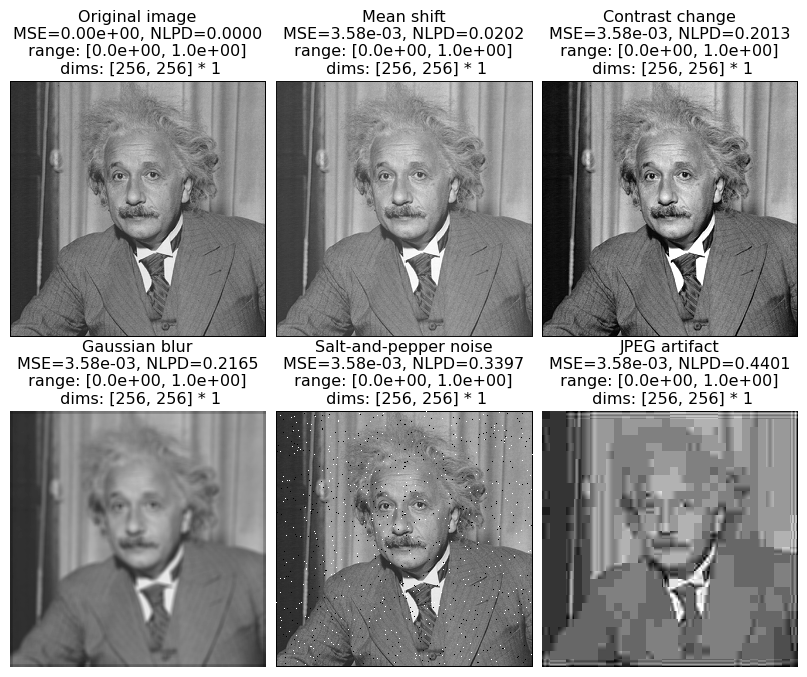

In [6]:
nlpd_values = po.metric.nlpd(img_distorted, img_distorted[[0]])[:, 0]
titles = [
    f"{names[i]}\nMSE={mse_values[i]:.2e}, NLPD={nlpd_values[i]:.4f}" for i in range(6)
]
po.imshow(img_distorted, vrange="auto", title=titles, col_wrap=3);

Note that, unlike SSIM and MS-SSIM, NLPD is a *distance* and so smaller numbers mean that a pair of image are more similar. Thus, the above images are ranked from most to least similar to the original image.

## Usage

The basic usage of {func}`~plenoptic.metric.perceptual_distance.ssim`, {func}`~plenoptic.metric.perceptual_distance.ms_ssim` and {func}`~plenoptic.metric.perceptual_distance.nlpd` are the same: they take two arguments, the images to be compared, whose shapes should be in the format `(batch, channel, height, width)`. All these functions are designed for grayscale images, so the channel dimension is treated as another batch dimension. The height and width of the two arguments should be the same, and the batch and channel sizes of the two arguments should be broadcastable. The broadcasting is already demonstrated in the examples of SSIM, MS-SSIM and NLPD that use the Einstein image.

SSIM, MS-SSIM and NLPD are not scale-invariant. The input images should have values between 0 and 1. Otherwise, the result may be inaccurate, and we will raise a warning (but will still compute it).

In [7]:
# Take SSIM as an example here. The images in img_demo have a range of [0, 1].
val1 = po.metric.ssim(img_demo[[0]], img_demo[[1]])
val2 = po.metric.ssim(img_demo[[0]] * 255, img_demo[[1]] * 255)
# This produces a wrong result and triggers a warning: Image range falls
# outside [0, 1].
print(f"True SSIM: {float(val1):.4f}, rescaled image SSIM: {float(val2):.4f}")

True SSIM: 0.7703, rescaled image SSIM: 0.4048


/home/agent/workspace/neurorse_plenoptic_PR-405/lib/python3.12/site-packages/plenoptic/metric/perceptual_distance.py:87: UserWarning: Image range falls outside [0, 1]. SSIM output may not make sense.
  warnings.warn(


## Comparison of performance

The performance of these perceptual distance metrics can be measured by the correlation with human psychophysics data: the TID2013 dataset consists of 3000 different distorted images (25 clean images x 24 types of distortions x 5 levels of distortions), each with its own mean opinion score (the perceived quality of the distorted image). Higher mean opinion score means a smaller distance from its corresponding clean image. The TID2013 dataset is described in the following paper:

[Ponomarenko, N., Jin, L., Ieremeiev, O., Lukin, V., Egiazarian, K., Astola, J., ... & Kuo, C. C. J. (2015). Image database TID2013: Peculiarities, results and perspectives. _Signal processing: Image communication_, 30, 57-77.](https://www.sciencedirect.com/science/article/pii/S0923596514001490)

Since both SSIM and MS-SSIM have higher values for less different image pairs, and are maximized at 1 for identical images, we need to convert them to distances as 1-SSIM and 1-(MS-SSIM). Then we will plot mean opinion score against the three metrics: 1-SSIM, 1-(MS-SSIM) and NLPD, as well as the baseline RMSE (square root of mean square error). We will also measure the correlation.

:::{attention}
To execute this part of the notebook, the TID2013 dataset needs to be downloaded. Note that the dataset is fairly large, about 1GB.
:::

In [8]:
def get_tid2013_data():
    folder = po.data.fetch_data("tid2013.tar.gz")
    reference_images = sorted((folder / "reference_images").iterdir())
    reference_images = po.load_images(reference_images)
    # disorted_images file names are of the form "i##_##_#.bmp" (and both the i and
    # the bmp can be either upper or lower case). the following sorts them by the
    # numbers in the order they appear
    distorted_images = sorted(
        (folder / "distorted_images").iterdir(), key=lambda p: p.stem[1:].split("_")
    )
    distorted_images = po.load_images(distorted_images)
    # reshape the tensor so that the first dimension corresponds to the reference image,
    # the second the distortion type, and the third the sample
    distorted_images = distorted_images.reshape((25, 24, 5, 1, 384, 512))

    # Remove color distortions
    non_color_distorts = [0] + list(range(2, 17)) + list(range(18, 24))
    distorted_images = distorted_images[:, non_color_distorts]

    with open(folder / "mos.txt", encoding="utf-8") as g:
        mos_values = list(map(float, g.readlines()))
    mos_values = np.array(mos_values).reshape([25, 24, 5])
    # Remove color distortions
    mos_values = mos_values[:, [0] + list(range(2, 17)) + list(range(18, 24))]
    return reference_images, distorted_images, mos_values

  0%|                                   | 1.02k/1.23G [00:01<580:48:06, 587B/s]

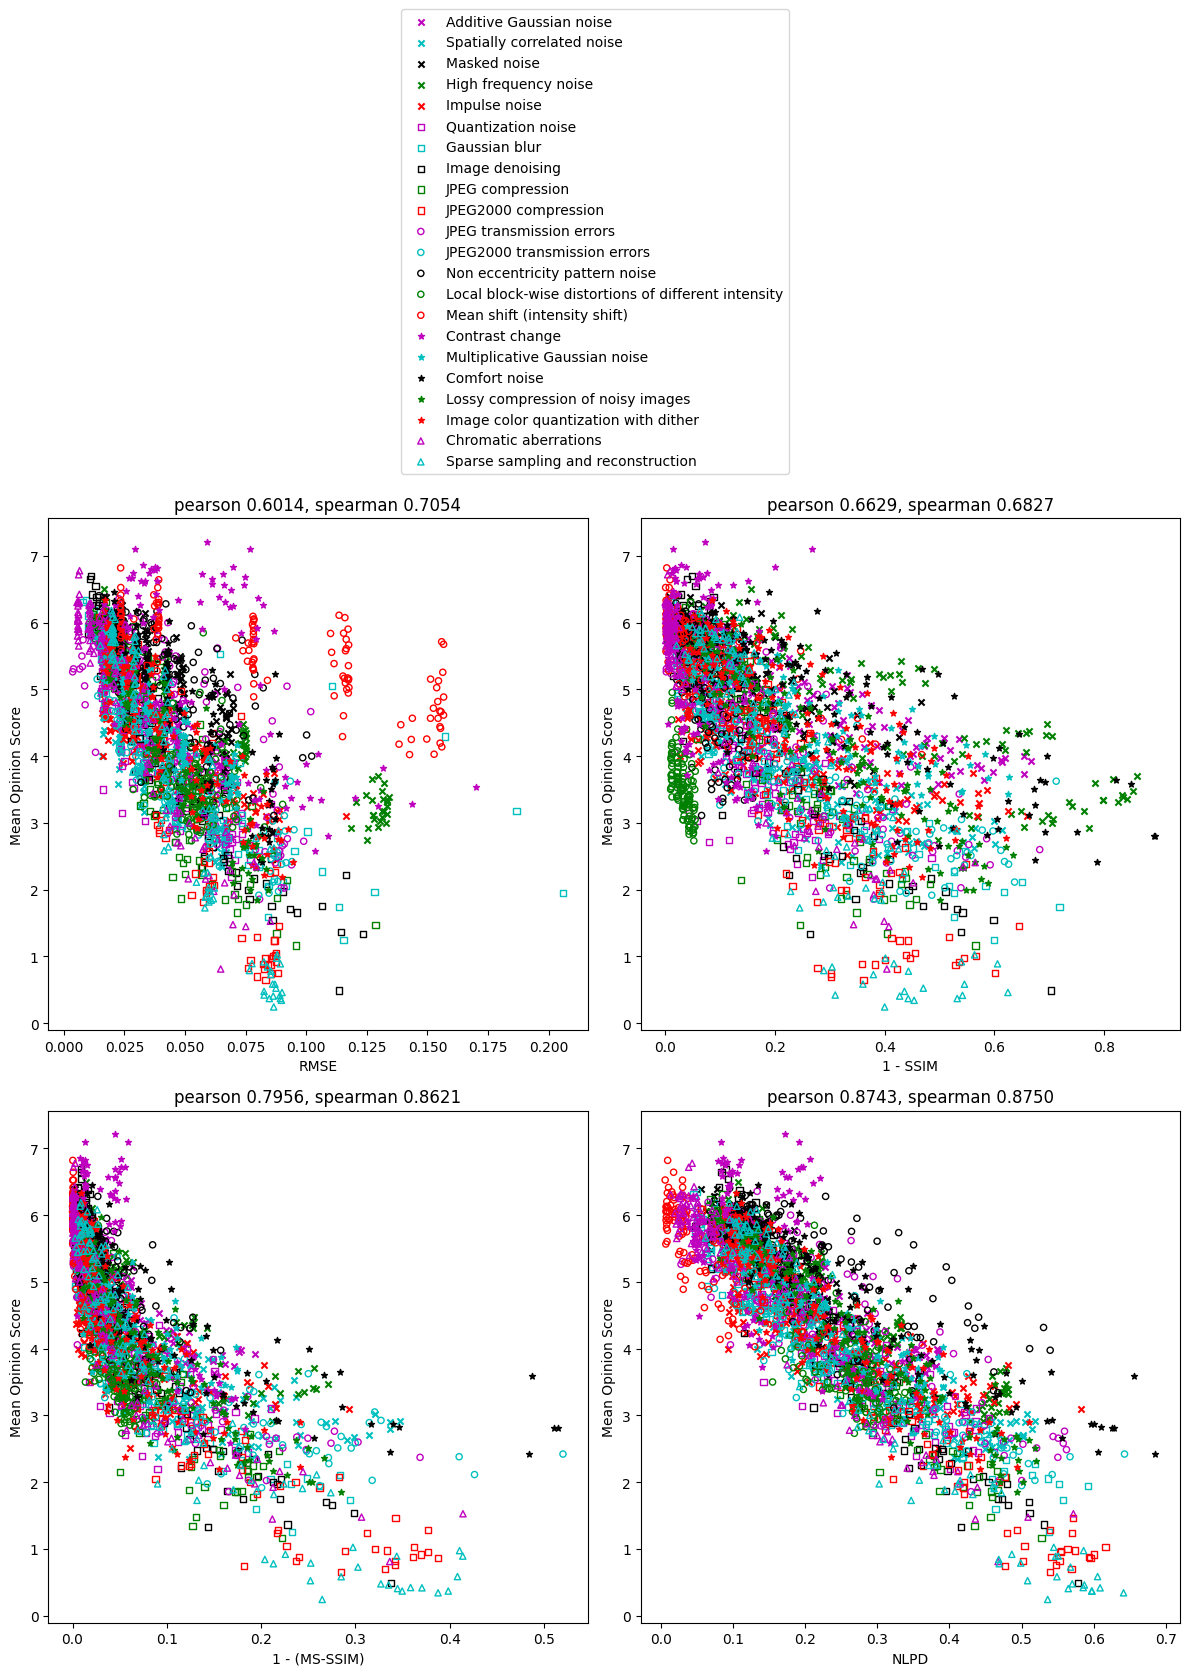

In [9]:
def correlate_with_tid(func_list, name_list):
    reference_images, distorted_images, mos_values = get_tid2013_data()
    distance = torch.zeros([len(func_list), 25, 22, 5])
    for i, func in enumerate(func_list):
        for j in range(25):
            distance[i, j] = func(
                reference_images[[j]], distorted_images[j].flatten(0, 1)
            ).reshape(22, 5)

    plot_size = int(np.ceil(np.sqrt(len(func_list))))
    fig, axs = plt.subplots(
        plot_size,
        plot_size,
        squeeze=False,
        figsize=(plot_size * 6, plot_size * 6),
    )
    axs = axs.flatten()
    edgecolor_list = ["m", "c", "k", "g", "r"]
    facecolor_list = [None, "none", "none", None, "none"]
    shape_list = ["x", "s", "o", "*", "^"]
    distortion_names = [
        "Additive Gaussian noise",
        "Spatially correlated noise",
        "Masked noise",
        "High frequency noise",
        "Impulse noise",
        "Quantization noise",
        "Gaussian blur",
        "Image denoising",
        "JPEG compression",
        "JPEG2000 compression",
        "JPEG transmission errors",
        "JPEG2000 transmission errors",
        "Non eccentricity pattern noise",
        "Local block-wise distortions of different intensity",
        "Mean shift (intensity shift)",
        "Contrast change",
        "Multiplicative Gaussian noise",
        "Comfort noise",
        "Lossy compression of noisy images",
        "Image color quantization with dither",
        "Chromatic aberrations",
        "Sparse sampling and reconstruction",
    ]

    for i, name in enumerate(name_list):
        for j in range(22):
            edgecolor = edgecolor_list[j % 5]
            facecolor = facecolor_list[j // 5]
            if facecolor is None:
                facecolor = edgecolor
                edgecolor = None
            axs[i].scatter(
                distance[i, :, j].flatten(),
                mos_values[:, j].flatten(),
                s=20,
                edgecolors=edgecolor,
                facecolors=facecolor,
                marker=shape_list[j // 5],
                label=distortion_names[j],
            )
        pearsonr_value = pearsonr(-mos_values.flatten(), distance[i].flatten())[0]
        spearmanr_value = spearmanr(-mos_values.flatten(), distance[i].flatten())[0]
        axs[i].set_title(
            f"pearson {pearsonr_value:.4f}, spearman {spearmanr_value:.4f}"
        )
        axs[i].set_xlabel(name)
        axs[i].set_ylabel("Mean Opinion Score")
    lines, labels = axs[0].get_legend_handles_labels()
    fig.legend(lines, labels, loc="lower center", bbox_to_anchor=(0.5, 1.0))
    plt.tight_layout()
    plt.show()


def rmse(img1, img2):
    return torch.sqrt(torch.square(img1 - img2).mean(dim=(-2, -1)))


def one_minus_ssim(img1, img2):
    return 1 - po.metric.ssim(img1, img2)


def one_minus_msssim(img1, img2):
    return 1 - po.metric.ms_ssim(img1, img2)


# This takes some minutes to run
correlate_with_tid(
    func_list=[rmse, one_minus_ssim, one_minus_msssim, po.metric.nlpd],
    name_list=["RMSE", "1 - SSIM", "1 - (MS-SSIM)", "NLPD"],
)

Each point in the figures is a distorted image, and the color/shape indicates the distortion type. The goodness of the perceptual distance metrics can be qualitatively assessed by looking at how well the points follow a monotonic function, and how straight this monotonic function is. We can see that points for RMSE and 1-SSIM are more scattered than 1-(MS-SSIM) and NLPD. The points for NLPD follows a much straighter line than other methods. The points for RMSE have outliers belonging to certain distortion types, notably mean shift and contrast change, while all three perceptual distance metrics are able to handle them better.

For a quantitative comparison, we calculate the Pearson's and Spearman's correlation coefficient between mean opinion score and each perceptual distance metric (shown above the figures). Pearson's correlation measures linear relationship, while Spearman's correlation allows a nonlinear relationship since it only depends on ranking. We can see that the performance of the metrics, as measured by the correlation coefficients, is: NLPD > MS-SSIM > SSIM > RMSE.